# Problem  Statement : Classify the post in to one of the two categories?

In [69]:
#!pip install wordcloud
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import requests

import pandas as pd
import numpy as np
import sys 
import regex as re
sys.path.insert(0, '/Users/mybiyani/Desktop/ga/common_code/')
from eda  import Helper
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import stop_words
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder 

In [70]:
edahelper =Helper()

Hello World!


## Gather and prepare your data using the requests library.
Using Pushshift's API, you'll collect posts from two subreddits of your choosing.

In [71]:
subreddits_list= ['travel','food','todayilearned','Relationships']
#subreddits_list= ['travel','food']
reddit_post_features = ['title','subreddit','created_utc']

In [72]:
'''  Get the specified numer of Subreddit posts for a given sub-reddit'''
def get_submission( subreddit, n = 500 ):
    df= pd.DataFrame()
    base_url ='https://api.pushshift.io/'
    submission_url = base_url + '/reddit/search/submission'
    epoch_min_ts =  1580171621 #  EPOCH timestamp for Jan 27 2020  now
    batch_size=500
    for i in range(int(n/batch_size)):
        
        params ={'subreddit' :subreddit ,'size' :batch_size, 'sort' :'desc','sort_type':'created_utc' ,'before' :epoch_min_ts }
        response = requests.get(submission_url,params)
        if( response.status_code !=200):
            print(f"Api call failed with error {response.status_code }")
        else:
            print(f"{subreddit} - getting batch {i+1} of  500 posts....for {epoch_min_ts}")
        submissions =response.json()
        posts = submissions['data']
        dfi =pd.DataFrame(posts) 
        dfi['created_utc_dt'] = dfi['created_utc'].apply(lambda x: pd.Timestamp(x,unit='s'))
        epoch_min_ts =dfi['created_utc'].min()
        df= pd.concat([df,dfi],sort=False) 
    print(f"Retrieved {len(df)} posts for{subreddit} from {df['created_utc_dt'].min()} to {df['created_utc_dt'].max()}")   
    return df
#---------------------------------------------------------------------------------------------------
df_subreddit = pd.DataFrame()
for i in range(len(subreddits_list)):  
     dfi = get_submission(subreddits_list[i])
     df_subreddit = pd.concat([df_subreddit,dfi])


travel - getting batch 1 of  500 posts....for 1580171621
Retrieved 500 posts fortravel from 2020-01-26 02:46:43 to 2020-01-28 00:33:29
food - getting batch 1 of  500 posts....for 1580171621
Retrieved 500 posts forfood from 2020-01-27 01:02:22 to 2020-01-28 00:30:23


/Users/mybiyani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



todayilearned - getting batch 1 of  500 posts....for 1580171621
Retrieved 500 posts fortodayilearned from 2020-01-26 19:14:46 to 2020-01-28 00:23:51
Relationships - getting batch 1 of  500 posts....for 1580171621
Retrieved 500 posts forRelationships from 2020-01-27 09:33:57 to 2020-01-28 00:31:59


In [73]:
df_subreddit['subreddit'].value_counts()

todayilearned    500
relationships    500
food             500
travel           500
Name: subreddit, dtype: int64

In [74]:
len(df_subreddit)

2000

In [75]:
df_subreddit.to_csv('offline_travel_food_small.csv',index =False)

## EDA

In [76]:
df_subreddit[df_subreddit['subreddit'] !='travel'][reddit_post_features]

,title,subreddit,created_utc
0,"[Homemade] Hot ham off the bone, Colby cheese,...",food,1580171423
1,[homemade] creamy parmesan spinach chicken,food,1580171406
2,Galaxy chocolate fudge cake messy but nice.,food,1580171393
3,What is this spice I bought at an African (mai...,food,1580171316
4,"[homemade]Lamb burger with cheddar, bacon, let...",food,1580171175
...,...,...,...
495,I (18M) was wondering if it’s worth risking as...,relationships,1580118017
496,[Update] I (30M) was right being worried about...,relationships,1580118009
497,My friend's house was a pig stye i lightly jok...,relationships,1580117863
498,"Seeking perspective (F, 29) on potential partn...",relationships,1580117844


In [77]:
edahelper.inspect_dataset(df_subreddit,'subreddit')

* We have 2000 number of rows 75 number of columns
* Numeric column count :32
* Numeric  columns :
---------------------
allow_live_comments                 bool
author_patreon_flair                bool
author_premium                      bool
can_mod_post                        bool
contest_mode                        bool
created_utc                        int64
created_utc_dt            datetime64[ns]
is_crosspostable                    bool
is_meta                             bool
is_original_content                 bool
is_reddit_media_domain              bool
is_robot_indexable                  bool
is_self                             bool
is_video                            bool
locked                              bool
media_only                          bool
no_follow                           bool
num_comments                       int64
num_crossposts                     int64
over_18                             bool
pinned                              bool
pwls              

In [78]:
def create_bag_of_words(msg):
    #1 remove anything other than alphabets
    letters_only = re.sub("[^a-zA-Z]", " ", msg) # Remove non-letters.
    words = letters_only.lower().split()  #Convert to lower case, split into individual words.
    ps= PorterStemmer()
    base_words =[ps.stem(w) for w  in words] 
    return(" ".join(base_words))# 6. Join the words back into one string separated by space, 

df_subreddit['title'] = df_subreddit['title'].apply(create_bag_of_words)
df_subreddit[df_subreddit['subreddit'] !='travel'][reddit_post_features]

,title,subreddit,created_utc
0,homemad hot ham off the bone colbi chees and h...,food,1580171423
1,homemad creami parmesan spinach chicken,food,1580171406
2,galaxi chocol fudg cake messi but nice,food,1580171393
3,what is thi spice i bought at an african mainl...,food,1580171316
4,homemad lamb burger with cheddar bacon lettuc ...,food,1580171175
...,...,...,...
495,i m wa wonder if it s worth risk ask out a fri...,relationships,1580118017
496,updat i m wa right be worri about my relations...,relationships,1580118009
497,my friend s hous wa a pig stye i lightli joke ...,relationships,1580117863
498,seek perspect f on potenti partner m,relationships,1580117844


#### Convert the Target variable to the  numerical value

In [79]:
le =LabelEncoder()
df_subreddit["subreddit_num"] =le.fit_transform(df_subreddit["subreddit"])

####  Base line score - 50 %

In [80]:
df_subreddit['subreddit'].value_counts()

todayilearned    500
relationships    500
food             500
travel           500
Name: subreddit, dtype: int64

In [81]:
df_subreddit['subreddit_num'].value_counts(normalize=True)

3    0.25
2    0.25
1    0.25
0    0.25
Name: subreddit_num, dtype: float64

In [82]:
df_subreddit[['title','subreddit', 'subreddit_num']].head()

,title,subreddit,subreddit_num
0,germani franc belgium netherland with month ol...,travel,3
1,chongq is beauti even if no one is out right n...,travel,3
2,first time visit budapest in earli octob,travel,3
3,chongq from jiefangbei district the build are ...,travel,3
4,i wa look for good travel channel and i found ...,travel,3


# Create models


######  Split the data in training and testing set


In [83]:
X =df_subreddit['title']
y=df_subreddit['subreddit_num']
X_train, X_test, y_train,y_test= train_test_split(X,y,test_size =0.33 ,random_state=42, stratify =y)

In [84]:
cv = CountVectorizer(stop_words='english')
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
print(f"CountVectorizer Total features = {len(cv.get_feature_names())}")
words = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())
words.sum().sort_values(ascending=False).head(20)

CountVectorizer Total features = 3687


til             293
homemad         201
wa              174
year             80
thi              71
travel           69
boyfriend        55
hi               55
ate              52
friend           52
relationship     48
best             47
like             45
ha               44
new              44
know             44
kobe             44
girlfriend       43
feel             43
time             41
dtype: int64

In [100]:
# Let's look at the most frequently used words.
cv = TfidfVectorizer(stop_words='english')
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
print(f"TfidfVectorizer Total features = {len(cv.get_feature_names())}")
words = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())
words.sum().sort_values(ascending=False).head(20)

TfidfVectorizer Total features = 3687


homemad         44.257612
til             31.713198
wa              22.812710
travel          19.501076
relationship    16.887103
ate             16.756193
thi             16.586423
boyfriend       16.389258
year            16.310440
friend          14.923926
best            14.507155
feel            13.486136
girlfriend      13.417889
know            12.923209
need            12.759418
kobe            11.801250
like            11.498839
advic           11.494596
help            11.421027
new             10.526103
dtype: float64

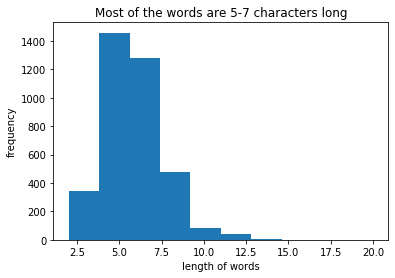

In [101]:
# Plot the lengths of the words.
lengths_of_words = [len(each) for each in words.columns]
plt.hist(lengths_of_words)
plt.xlabel("length of words")
plt.ylabel("frequency")
plt.title('Most of the words are 5-7 characters long');

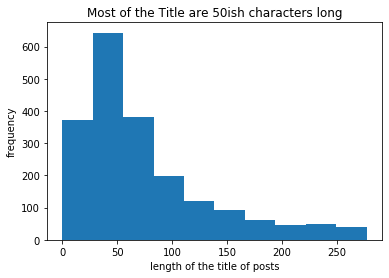

In [102]:
# Plot the lengths of the posts.
lengths_of_posts = [len(each) for each in X]
plt.hist(lengths_of_posts)
plt.xlabel("length of the title of posts")
plt.ylabel("frequency")
plt.title('Most of the Title are 50ish characters long');

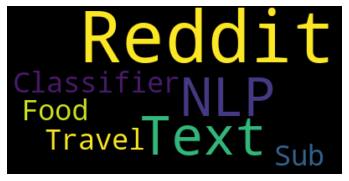

In [103]:

text = 'Reddit NLP Text Classifier Sub-reddit Travel Food'

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [104]:
np.sqrt(6876)

82.92164976651152

##  Naive Bayes

In [105]:
def evaluate_classifier(model,vectorizer,md,X_test,y_test):
    y_pred = md.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred,labels=[0,1]).ravel()  
    
    cvs =np.round(cross_val_score(md, X_train, y_train, cv=3).mean(),2)
    tr_sc =np.round(md.score(X_train,y_train),2)
    te_sc = np.round(md.score(X_test,y_test),2)
    sensitivity = np.round(((tp)/(tp+fn))*100,2)
    specificity = np.round(((tn)/(tn+fp))*100,2)
    print(f"|{model}-{vectorizer}|{cvs}|{tr_sc}|{te_sc}|{tn}|{fp}|{fn}|{tp}|{sensitivity}%|{specificity}%")
    return y_pred
    

In [106]:
def classify_posts(model ='Bernoilli',vectorizer='Count'):
    X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y)
    
    v= TfidfVectorizer(stop_words='english',max_features =100) if(vectorizer =='TFID') else CountVectorizer(stop_words='english',max_features =100)
    pipe = Pipeline([ 
                     ('vec' ,v ) ,
                      ('mnb', BernoulliNB())])
    
    if(model =='Multinomial'):
        pipe = Pipeline([ 
                     ('vec' , v) , 
                      ('mnb', MultinomialNB())])
        
    elif(model =="LogisticRegression"):
        pipe =Pipeline([
            ('vec',v),
            ('lr',LogisticRegression(solver='liblinear'))
        ])
        
    elif(model =='knn'):
        pipe= Pipeline([
            ('vec',v),
             ('knn',KNeighborsClassifier())
        ])
    elif(model =='SVM'):
        pipe= Pipeline([
            ('vec',v),
            ('svc',SVC(gamma="scale"))
        ])
    
    pipe.fit(X_train,y_train)
#    print(len(v.get_feature_names()))
    y_pred = evaluate_classifier(model,vectorizer,pipe,X_test,y_test)
    return y_pred
    
print("|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity")
print("|---|---|---|---|---|---|---|---|---|---|")

classify_posts("Bernoilli",'Count')
classify_posts("Bernoilli",'TFID')

classify_posts("Multinomial",'Count')
classify_posts("Multinomial",'TFID')

classify_posts('knn','Count')
classify_posts('knn','TFID')

classify_posts("LogisticRegression",'Count')
classify_posts("LogisticRegression",'TFID')

classify_posts('SVM','Count')
classify_posts('SVM','TFID')

|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
|Bernoilli-Count|0.85|0.87|0.86|105|1|0|92|100.0%|99.06%
|Bernoilli-TFID|0.85|0.87|0.87|105|4|0|101|100.0%|96.33%
|Multinomial-Count|0.78|0.81|0.77|116|1|18|100|84.75%|99.15%
|Multinomial-TFID|0.77|0.8|0.77|119|1|18|96|84.21%|99.17%
|knn-Count|0.75|0.86|0.83|96|6|6|97|94.17%|94.12%
|knn-TFID|0.71|0.77|0.72|99|22|0|107|100.0%|81.82%
|LogisticRegression-Count|0.84|0.87|0.85|98|0|0|90|100.0%|100.0%


/Users/mybiyani/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mybiyani/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mybiyani/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mybiyani/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this wa

|LogisticRegression-TFID|0.85|0.87|0.83|100|3|0|96|100.0%|97.09%
|SVM-Count|0.84|0.88|0.82|88|6|0|96|100.0%|93.62%
|SVM-TFID|0.84|0.9|0.84|100|3|1|96|98.97%|97.09%


array([1, 0, 2, 2, 3, 1, 3, 3, 0, 0, 0, 3, 1, 3, 2, 3, 0, 3, 3, 3, 0, 2,
       0, 2, 2, 0, 1, 2, 2, 1, 3, 3, 1, 1, 2, 1, 0, 2, 2, 3, 1, 3, 3, 3,
       3, 3, 1, 3, 3, 0, 0, 1, 3, 1, 3, 0, 0, 3, 1, 0, 2, 2, 1, 2, 0, 3,
       3, 3, 3, 1, 3, 1, 0, 1, 3, 0, 3, 3, 0, 3, 3, 1, 0, 0, 1, 3, 2, 2,
       0, 3, 0, 2, 0, 0, 3, 3, 3, 0, 1, 1, 2, 3, 0, 2, 3, 1, 2, 1, 2, 3,
       3, 0, 3, 1, 2, 1, 2, 0, 2, 3, 1, 3, 3, 3, 1, 1, 3, 0, 2, 1, 1, 1,
       2, 3, 2, 3, 1, 2, 1, 1, 0, 2, 2, 3, 0, 0, 3, 0, 0, 1, 3, 3, 3, 0,
       1, 2, 3, 0, 2, 0, 2, 0, 3, 2, 2, 1, 1, 3, 3, 3, 1, 3, 1, 2, 1, 3,
       1, 3, 0, 1, 3, 1, 1, 1, 3, 3, 2, 2, 3, 3, 3, 3, 1, 0, 3, 2, 0, 0,
       3, 0, 2, 3, 0, 1, 3, 2, 0, 3, 3, 3, 1, 0, 0, 3, 2, 1, 3, 1, 0, 2,
       2, 2, 3, 1, 2, 0, 3, 2, 0, 3, 2, 2, 0, 3, 1, 3, 3, 0, 2, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3,
       3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 3, 0, 1, 3, 3, 1, 3, 3, 2, 0, 3,
       1, 0, 0, 1, 3, 2, 3, 0, 3, 3, 2, 1, 3, 1, 0,

|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
|Bernoilli-Count|0.92|0.92|0.92|10526|1974|98|12402|99.22%|84.21%
|Bernoilli-TFID|0.92|0.92|0.92|10597|1903|100|12400|99.2%|84.78%
|Multinomial-Count|0.81|0.81|0.81|11884|616|4133|8367|66.94%|95.07%
|Multinomial-TFID|0.81|0.81|0.81|11898|602|4073|8427|67.42%|95.18%
|LogisticRegression-Count|0.92|0.92|0.92|10668|1832|113|12387|99.1%|85.34%
|LogisticRegression-TFID|0.92|0.92|0.92|10756|1744|131|12369|98.95%|86.05%

In [107]:
df_subreddit['subreddit_pred'] =pd.Series(classify_posts("Multinomial",'TFID'))

|Multinomial-TFID|0.77|0.79|0.76|115|6|23|92|80.0%|95.04%


In [120]:
cm= confusion_matrix(df_subreddit['subreddit_num'],df_subreddit['subreddit_pred'])

array([[196, 109, 130,  65],
       [196, 109, 130,  65],
       [196, 109, 130,  65],
       [196, 109, 130,  65]])

In [94]:
def classify_posts_tune(model ='Bernoilli',vectorizer='Count'):
    X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y)
    
    v= TfidfVectorizer() if(vectorizer =='TFID') else CountVectorizer()
    pipe = Pipeline([ 
                     ('vec' ,v ) ,
                      ('mnb', BernoulliNB())])
    
    if(model =='Multinomial'):
        pipe = Pipeline([ 
                     ('vec' , v) , 
                      ('mnb', MultinomialNB())])
        

    
    pipe.fit(X_train,y_train)
    pipe_params = {
    'vec__max_features': [100,1000,2000,3000,4000,5000,6000],
    'vec__stop_words' :[stop_words.ENGLISH_STOP_WORDS,None],
    'vec__ngram_range': [(1,1), (1,2)]
     }
    gs =GridSearchCV(pipe,pipe_params, cv=5)
    gs.fit(X_train,y_train)
    print( gs.best_params_)

    evaluate_classifier(gs,vectorizer,pipe,X_test,y_test)
    
#----------------------------------------------------------------------------------    
print("|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity")
print("|---|---|---|---|---|---|---|---|---|---|")

classify_posts_tune("Bernoilli",'Count')
classify_posts_tune("Bernoilli",'TFID')

classify_posts_tune("Multinomial",'Count')
classify_posts_tune("Multinomial",'TFID')


|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
{'vec__max_features': 1000, 'vec__ngram_range': (1, 1), 'vec__stop_words': frozenset({'four', 'detail', 'de', 'thereupon', 'too', 'sixty', 'further', 'we', 'when', 'however', 'except', 'indeed', 'am', 'any', 'put', 'along', 'several', 'thence', 'co', 'where', 'hereby', 'etc', 'wherein', 'see', 'together', 'become', 'already', 'yet', 'what', 'above', 'found', 'rather', 'least', 'move', 'top', 'elsewhere', 'nor', 'down', 'ie', 'do', 'than', 'forty', 'the', 'themselves', 'even', 'somehow', 'i', 'sincere', 'himself', 'each', 'of', 'fire', 'enough', 'afterwards', 'everything', 'is', 'upon', 'was', 'would', 'everyone', 'toward', 'due', 'whereby', 'latter', 'alone', 'amoungst', 'hereafter', 'eight', 'whether', 'twenty', 'should', 'again', 'often', 'been', 'him', 'less', 'empty', 'hundred', 'they', 'after', 'whereas', 'had', 'has', 'via', 'twelve', 'none', 'now', 'must', 'a

{'vec__max_features': 3000, 'vec__ngram_range': (1, 1), 'vec__stop_words': frozenset({'four', 'detail', 'de', 'thereupon', 'too', 'sixty', 'further', 'we', 'when', 'however', 'except', 'indeed', 'am', 'any', 'put', 'along', 'several', 'thence', 'co', 'where', 'hereby', 'etc', 'wherein', 'see', 'together', 'become', 'already', 'yet', 'what', 'above', 'found', 'rather', 'least', 'move', 'top', 'elsewhere', 'nor', 'down', 'ie', 'do', 'than', 'forty', 'the', 'themselves', 'even', 'somehow', 'i', 'sincere', 'himself', 'each', 'of', 'fire', 'enough', 'afterwards', 'everything', 'is', 'upon', 'was', 'would', 'everyone', 'toward', 'due', 'whereby', 'latter', 'alone', 'amoungst', 'hereafter', 'eight', 'whether', 'twenty', 'should', 'again', 'often', 'been', 'him', 'less', 'empty', 'hundred', 'they', 'after', 'whereas', 'had', 'has', 'via', 'twelve', 'none', 'now', 'must', 'all', 'without', 'about', 'thereafter', 'seeming', 'there', 'many', 'thru', 'were', 'system', 'take', 'could', 'his', 'thre

#### 1. Results summary. - Categories - Travel and Food

|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
|Bernoilli-Count|0.95|0.97|0.96|1189|61|30|1220|97.6%|95.12%
|Bernoilli-TFID|0.95|0.97|0.96|1181|69|37|1213|97.04%|94.48%
|Multinomial-Count|0.96|0.97|0.96|1178|72|31|1219|97.52%|94.24%
|Multinomial-TFID|0.96|0.98|0.96|1196|54|41|1209|96.72%|95.68%
|knn-Count|0.81|0.89|0.83|1172|78|346|904|72.32%|93.76%
|knn-TFID|0.61|0.76|0.66|985|265|589|661|52.88%|78.8%
|LogisticRegression-Count|0.95|0.98|0.96|1163|87|15|1235|98.8%|93.04%
|LogisticRegression-TFID|0.95|0.97|0.96|1163|87|11|1239|99.12%|93.04%
|SVM-Count|0.94|0.97|0.94|1115|135|5|1245|99.6%|89.2%
|SVM-TFID|0.96|0.99|0.97|1175|75|6|1244|99.52%|94.0%

In [95]:
### Results  2  with 50000 posts for each rub-reddit

|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
|Bernoilli-Count|0.92|0.92|0.92|10572|1928|102|12398|99.18%|84.58%
|Bernoilli-TFID|0.92|0.92|0.92|10589|1911|114|12386|99.09%|84.71%
|Multinomial-Count|0.81|0.81|0.81|11917|583|4113|8387|67.1%|95.34%
|Multinomial-TFID|0.81|0.81|0.81|11887|613|4165|8335|66.68%|95.1%
|LogisticRegression-Count|0.92|0.92|0.93|10751|1749|118|12382|99.06%|86.01%
|LogisticRegression-TFID|0.92|0.92|0.93|10806|1694|135|12365|98.92%|86.45%
|SVM-Count|0.92|0.93|0.92|10753|1747|173|12327|98.62%|86.02%
|SVM-TFID|0.92|0.93|0.92|10772|1728|151|12349|98.79%|86.18%

In [96]:
### Parameter tuning for Naive Bays - 'vec__max_features': 6000, 'vec__ngram_range': (1, 1)

|Model Type|cvs| training score|test score| tn |fp|fn|tp|senitivity|specificity
|---|---|---|---|---|---|---|---|---|---|
|Bernoilli-Count|0.96|0.97|0.96|11852|648|286|12214|97.71%|94.82%
|Bernoilli-TFID|0.96|0.97|0.96|11867|633|305|12195|97.56%|94.94%
|Multinomial-Count|0.96|0.97|0.97|11878|622|252|12248|97.98%|95.02%
|Multinomial-TFID|0.96|0.97|0.96|11844|656|234|12266|98.13%|94.75%

# Conclusion
The results were promising as the model was simple and yet could accurately predict 97% percent of the time if a post belongs to a subreddit or not.  (accuracy)
For every correct 100 sumissions model agreed with 97 of them. (Sensitivity)
Similarly, for every 100 wrong messages that landed in the sub-reddit model could predicted 95 of them correctly.(Specificity)

While it might be some what expected as travel and food may not have a lot of overlapping words and classifier can do a pretty good job of putting them in the right buckets.

# References

https://www.youtube.com/watch?v=AcrjEWsMi_E&feature=youtu.be

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html

https://github.com/pushshift/api


https://git.generalassemb.ly/DSI-US-10/5.02-lesson-webscraping/blob/lecture-wc/Codealong.ipynb

https://api.pushshift.io/reddit/search/submission?subreddit=boardgames

https://www.epochconverter.com/


https://bigishdata.com/2016/12/05/classifying-amazon-reviews-with-scikit-learn-more-data-is-better-turns-out/

https://www.datacamp.com/community/tutorials/wordcloud-python